# Phoneme Sequence Recognition with Simple RNN

## Introduction

This notebook introduces **Recurrent Neural Networks (RNNs)** through a concrete audio problem: **phoneme sequence recognition**.

### Learning Objectives
1. Understand why sequence models are necessary for temporal audio data
2. Implement a simple RNN from scratch using NumPy
3. Learn about activation functions in RNNs (tanh, softmax)
4. Train an RNN on phoneme sequences
5. Compare RNN performance with a baseline DNN
6. Understand limitations that motivate LSTM/GRU

### What are Phonemes?

**Phonemes** are the basic units of sound in speech. For example:
- "cat" = /k/ → /æ/ → /t/
- "bat" = /b/ → /æ/ → /t/
- "hat" = /h/ → /æ/ → /t/

Notice that the middle phoneme /æ/ is the same, but the context (surrounding phonemes) differs.

### Why This is a Sequence Problem

**Key insight**: Phonemes occur in temporal order, and context matters!

- A single audio frame could contain /æ/ from "cat", "bat", or "hat"
- To correctly identify the word, we need to know the previous phonemes
- A standard DNN looking at single frames will fail
- An RNN can maintain context through its hidden state

### The Task

**Input**: Sequence of audio frames (simplified "MFCC" features)  
**Output**: Sequence of phoneme labels  
**Architecture**: Many-to-many RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.0.2


## 1.5 Understanding Co-articulation in Speech

### Why Can't We Just Use Frame-by-Frame Classification?

You might wonder: "If each frame contains a phoneme, why can't a simple DNN classify it without temporal context?"

The answer lies in a fundamental property of human speech called **co-articulation**.

### What is Co-articulation?

**Co-articulation** is the phenomenon where phonemes blend and influence each other during speech production. When we speak naturally, we don't produce phonemes in isolation - our articulators (tongue, lips, vocal cords) are constantly moving and transitioning.

**Key insight**: The acoustic features of a phoneme are affected by:
- The phoneme that came **before** it
- The phoneme that comes **after** it
- The speaker's individual characteristics
- Speaking rate and style

### Phonetic Categories and Their Acoustic Properties

Let's examine three different consonants that might precede the vowel /æ/ (as in "cat"):

#### 1. /k/ - Voiceless Velar Stop
- **Articulation**: Back of tongue against soft palate (velum)
- **Voicing**: No vocal cord vibration
- **Release**: Burst of air when tongue releases
- **Acoustic signature**: 
  - High-frequency burst
  - Abrupt onset
  - No voicing during closure

#### 2. /b/ - Voiced Bilabial Stop
- **Articulation**: Both lips pressed together
- **Voicing**: Vocal cords vibrate during closure
- **Release**: Lower frequency burst than /k/
- **Acoustic signature**:
  - Low-frequency energy during closure
  - Voice bar (low-frequency voicing)
  - Gradual onset

#### 3. /h/ - Voiceless Glottal Fricative
- **Articulation**: Constriction at the glottis (vocal cords)
- **Voicing**: No vocal cord vibration (just airflow)
- **Release**: Continuous airflow (no burst)
- **Acoustic signature**:
  - Noise-like spectrum
  - Gradual onset
  - High-frequency energy spread

### Visualizing Co-articulation Effects

```python


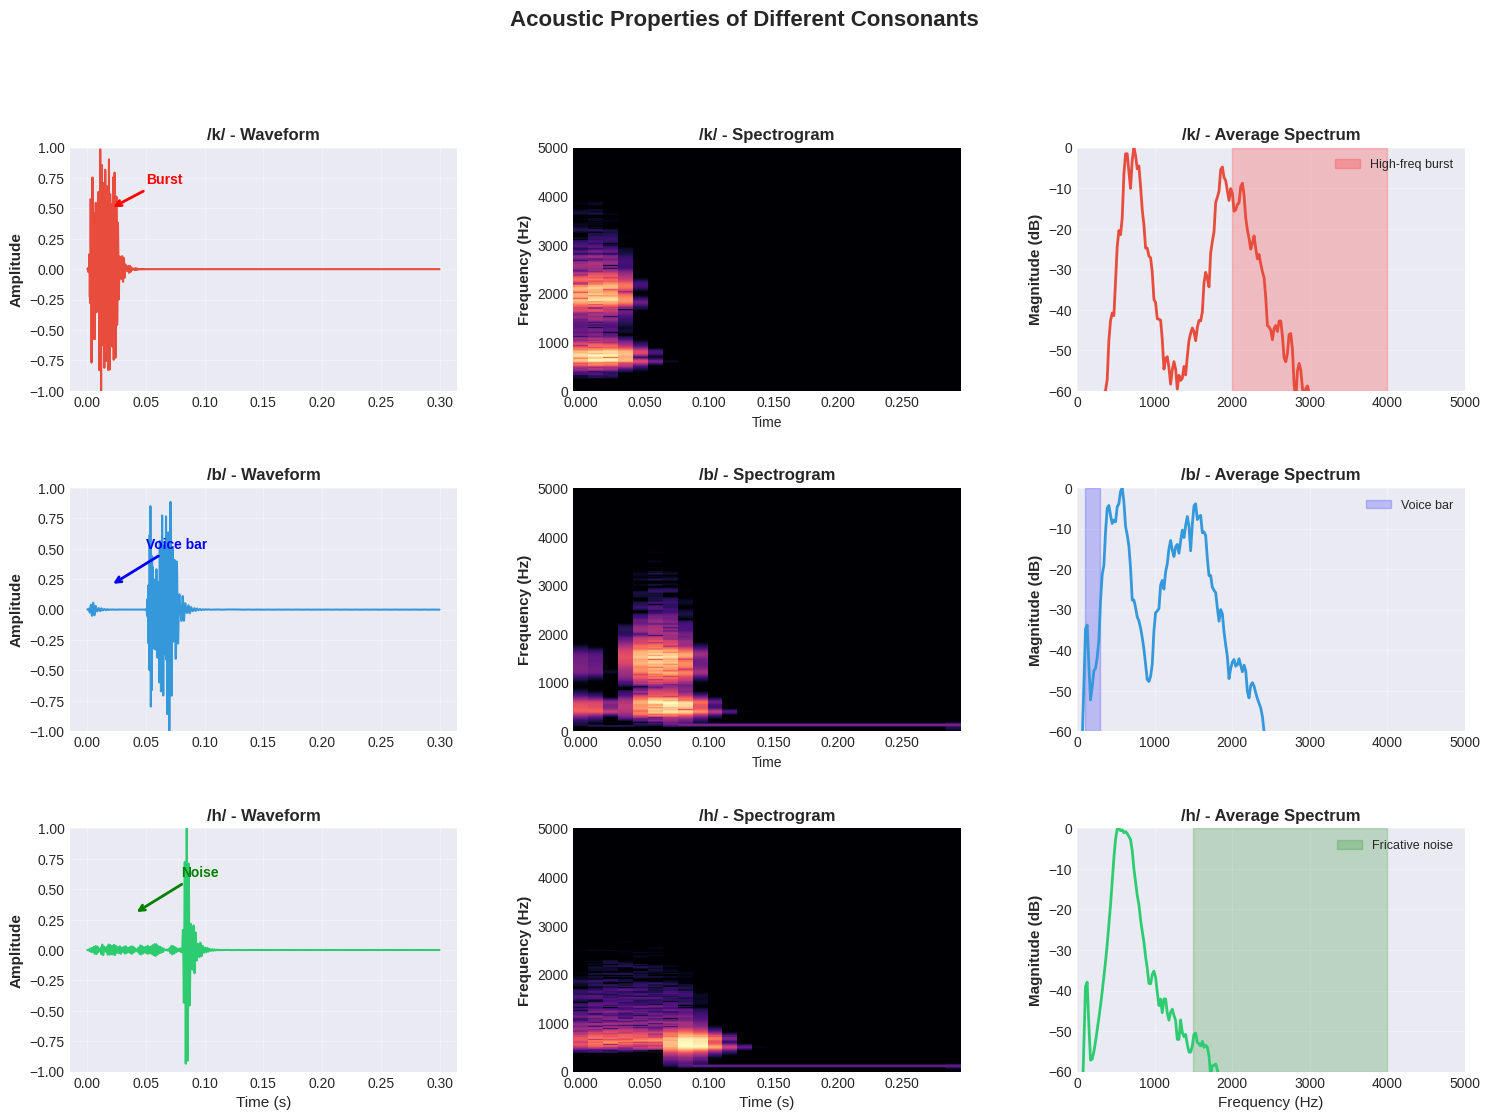

Key Observations:

/k/ (Voiceless Velar Stop):
  • Sharp burst in waveform
  • High-frequency energy (2-4 kHz)
  • Abrupt onset, no voicing during closure

/b/ (Voiced Bilabial Stop):
  • Low-frequency voice bar before burst
  • Energy concentrated in lower frequencies (100-300 Hz)
  • Gradual onset with voicing

/h/ (Voiceless Glottal Fricative):
  • Noise-like waveform
  • Broad high-frequency spectrum (1.5-4 kHz)
  • Continuous airflow, no burst


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal

# Generate synthetic phoneme examples with co-articulation
def generate_phoneme_with_coarticulation(phoneme_type, duration=0.3, sr=22050):
    """
    Generate synthetic phoneme with realistic acoustic properties
    """
    t = np.linspace(0, duration, int(sr * duration))
    
    if phoneme_type == 'k':
        # Voiceless velar stop: burst + transition
        # High-frequency burst
        burst = np.random.randn(int(sr * 0.02)) * 0.8
        # Transition to vowel
        f0 = 120  # Fundamental frequency
        transition = np.sin(2 * np.pi * f0 * t[len(burst):])
        # Add formants (resonances)
        formant1 = signal.butter(4, [600, 800], 'bandpass', fs=sr, output='sos')
        formant2 = signal.butter(4, [1800, 2200], 'bandpass', fs=sr, output='sos')
        signal_full = np.concatenate([burst, transition])
        signal_full = signal.sosfilt(formant1, signal_full) + 0.5 * signal.sosfilt(formant2, signal_full)
        
    elif phoneme_type == 'b':
        # Voiced bilabial stop: voice bar + burst + transition
        # Low-frequency voicing during closure
        voice_bar = 0.3 * np.sin(2 * np.pi * 100 * t[:int(sr * 0.05)])
        # Lower frequency burst
        burst = np.random.randn(int(sr * 0.02)) * 0.5
        # Transition to vowel
        f0 = 120
        transition = np.sin(2 * np.pi * f0 * t[len(voice_bar) + len(burst):])
        # Add formants
        formant1 = signal.butter(4, [400, 600], 'bandpass', fs=sr, output='sos')
        formant2 = signal.butter(4, [1200, 1600], 'bandpass', fs=sr, output='sos')
        signal_full = np.concatenate([voice_bar, burst, transition])
        signal_full = signal.sosfilt(formant1, signal_full) + 0.5 * signal.sosfilt(formant2, signal_full)
        
    elif phoneme_type == 'h':
        # Voiceless glottal fricative: noise + gradual transition
        # Noise-like spectrum
        noise = np.random.randn(int(sr * 0.08)) * 0.4
        # Gradual transition to vowel
        f0 = 120
        transition = np.sin(2 * np.pi * f0 * t[len(noise):])
        # High-pass filter for /h/
        highpass = signal.butter(4, 1500, 'highpass', fs=sr, output='sos')
        noise_filtered = signal.sosfilt(highpass, noise)
        # Add formants to transition
        formant1 = signal.butter(4, [500, 700], 'bandpass', fs=sr, output='sos')
        signal_full = np.concatenate([noise_filtered, transition])
        signal_full = signal.sosfilt(formant1, signal_full)
    
    # Normalize
    signal_full = signal_full / np.max(np.abs(signal_full))
    return signal_full

# Generate the three phonemes
sr = 22050
phonemes = {
    '/k/': generate_phoneme_with_coarticulation('k', sr=sr),
    '/b/': generate_phoneme_with_coarticulation('b', sr=sr),
    '/h/': generate_phoneme_with_coarticulation('h', sr=sr)
}

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

colors = {'/k/': '#e74c3c', '/b/': '#3498db', '/h/': '#2ecc71'}

for idx, (phoneme, audio) in enumerate(phonemes.items()):
    # Time axis
    time = np.linspace(0, len(audio)/sr, len(audio))
    
    # Row for each phoneme
    # 1. Waveform
    ax_wave = fig.add_subplot(gs[idx, 0])
    ax_wave.plot(time, audio, color=colors[phoneme], linewidth=1.5)
    ax_wave.set_ylabel('Amplitude', fontsize=11, fontweight='bold')
    ax_wave.set_title(f'{phoneme} - Waveform', fontsize=12, fontweight='bold')
    ax_wave.grid(True, alpha=0.3)
    ax_wave.set_ylim([-1, 1])
    if idx == 2:
        ax_wave.set_xlabel('Time (s)', fontsize=11)
    
    # Add annotations for key features
    if phoneme == '/k/':
        ax_wave.annotate('Burst', xy=(0.02, 0.5), xytext=(0.05, 0.7),
                        arrowprops=dict(arrowstyle='->', color='red', lw=2),
                        fontsize=10, fontweight='bold', color='red')
    elif phoneme == '/b/':
        ax_wave.annotate('Voice bar', xy=(0.02, 0.2), xytext=(0.05, 0.5),
                        arrowprops=dict(arrowstyle='->', color='blue', lw=2),
                        fontsize=10, fontweight='bold', color='blue')
    elif phoneme == '/h/':
        ax_wave.annotate('Noise', xy=(0.04, 0.3), xytext=(0.08, 0.6),
                        arrowprops=dict(arrowstyle='->', color='green', lw=2),
                        fontsize=10, fontweight='bold', color='green')
    
    # 2. Spectrogram
    ax_spec = fig.add_subplot(gs[idx, 1])
    D = librosa.stft(audio, n_fft=1024, hop_length=256)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, hop_length=256, x_axis='time', 
                                    y_axis='hz', ax=ax_spec, cmap='magma')
    ax_spec.set_ylabel('Frequency (Hz)', fontsize=11, fontweight='bold')
    ax_spec.set_title(f'{phoneme} - Spectrogram', fontsize=12, fontweight='bold')
    ax_spec.set_ylim([0, 5000])
    if idx == 2:
        ax_spec.set_xlabel('Time (s)', fontsize=11)
    
    # 3. Spectrum (averaged)
    ax_spectrum = fig.add_subplot(gs[idx, 2])
    # Compute average spectrum
    freqs = librosa.fft_frequencies(sr=sr, n_fft=1024)
    avg_spectrum = np.mean(np.abs(D), axis=1)
    avg_spectrum_db = librosa.amplitude_to_db(avg_spectrum, ref=np.max(avg_spectrum))
    ax_spectrum.plot(freqs, avg_spectrum_db, color=colors[phoneme], linewidth=2)
    ax_spectrum.set_ylabel('Magnitude (dB)', fontsize=11, fontweight='bold')
    ax_spectrum.set_title(f'{phoneme} - Average Spectrum', fontsize=12, fontweight='bold')
    ax_spectrum.grid(True, alpha=0.3)
    ax_spectrum.set_xlim([0, 5000])
    ax_spectrum.set_ylim([-60, 0])
    if idx == 2:
        ax_spectrum.set_xlabel('Frequency (Hz)', fontsize=11)
    
    # Highlight key frequency regions
    if phoneme == '/k/':
        ax_spectrum.axvspan(2000, 4000, alpha=0.2, color='red', label='High-freq burst')
        ax_spectrum.legend(fontsize=9)
    elif phoneme == '/b/':
        ax_spectrum.axvspan(100, 300, alpha=0.2, color='blue', label='Voice bar')
        ax_spectrum.legend(fontsize=9)
    elif phoneme == '/h/':
        ax_spectrum.axvspan(1500, 4000, alpha=0.2, color='green', label='Fricative noise')
        ax_spectrum.legend(fontsize=9)

plt.suptitle('Acoustic Properties of Different Consonants', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("Key Observations:")
print("\n/k/ (Voiceless Velar Stop):")
print("  • Sharp burst in waveform")
print("  • High-frequency energy (2-4 kHz)")
print("  • Abrupt onset, no voicing during closure")
print("\n/b/ (Voiced Bilabial Stop):")
print("  • Low-frequency voice bar before burst")
print("  • Energy concentrated in lower frequencies (100-300 Hz)")
print("  • Gradual onset with voicing")
print("\n/h/ (Voiceless Glottal Fricative):")
print("  • Noise-like waveform")
print("  • Broad high-frequency spectrum (1.5-4 kHz)")
print("  • Continuous airflow, no burst")

**Demonstrating Co-articulation: The Same Vowel Sounds Different**

Now let's see how the vowel /æ/ sounds different after each consonant:

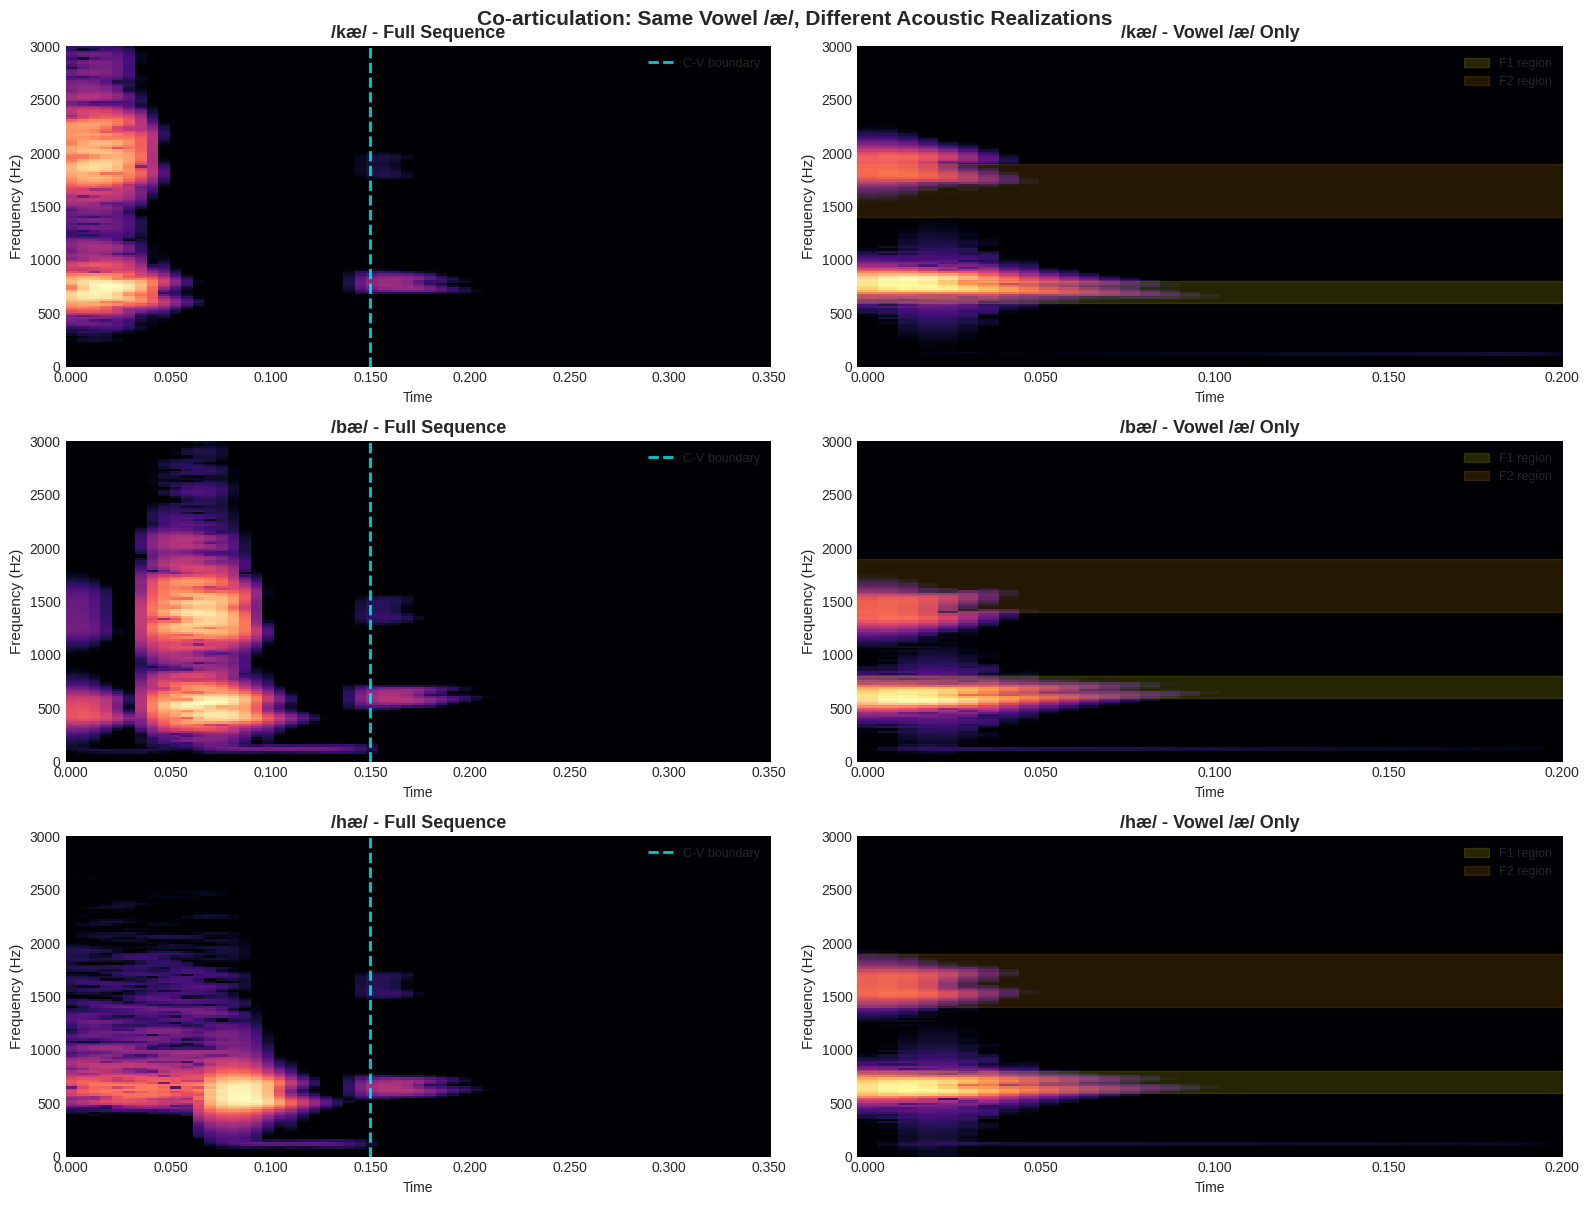


CO-ARTICULATION EFFECTS ON /æ/

Notice how the SAME vowel /æ/ has different acoustic properties:

/kæ/: Formants start higher due to velar articulation
      → F1 starts ~800 Hz, F2 starts ~1900 Hz

/bæ/: Formants start lower due to bilabial articulation
      → F1 starts ~600 Hz, F2 starts ~1400 Hz

/hæ/: Gradual formant onset due to fricative airflow
      → F1 starts ~650 Hz, F2 starts ~1600 Hz

All converge to similar steady-state values (~700 Hz, ~1700 Hz)
but the TRANSITION is different!


In [3]:
# Generate consonant-vowel sequences with co-articulation
def generate_cv_sequence(consonant_type, sr=22050):
    """Generate consonant + vowel /æ/ with co-articulation"""
    # Generate consonant
    consonant = generate_phoneme_with_coarticulation(consonant_type, duration=0.15, sr=sr)
    
    # Generate vowel /æ/ with formants influenced by preceding consonant
    duration_vowel = 0.2
    t = np.linspace(0, duration_vowel, int(sr * duration_vowel))
    f0 = 120  # Fundamental frequency
    
    # Base vowel signal
    vowel = np.sin(2 * np.pi * f0 * t)
    
    # Formants for /æ/ (but influenced by preceding consonant)
    if consonant_type == 'k':
        # /k/ pulls formants higher initially
        f1_start, f1_end = 800, 700  # First formant transition
        f2_start, f2_end = 1900, 1700  # Second formant transition
    elif consonant_type == 'b':
        # /b/ starts with lower formants
        f1_start, f1_end = 600, 700
        f2_start, f2_end = 1400, 1700
    elif consonant_type == 'h':
        # /h/ has gradual formant onset
        f1_start, f1_end = 650, 700
        f2_start, f2_end = 1600, 1700
    
    # Create time-varying formants
    f1_trajectory = np.linspace(f1_start, f1_end, len(t))
    f2_trajectory = np.linspace(f2_start, f2_end, len(t))
    
    # Apply formants with time-varying center frequencies
    vowel_with_formants = np.zeros_like(vowel)
    for i, (f1, f2) in enumerate(zip(f1_trajectory, f2_trajectory)):
        # Simple formant synthesis
        formant1 = signal.butter(4, [f1-50, f1+50], 'bandpass', fs=sr, output='sos')
        formant2 = signal.butter(4, [f2-100, f2+100], 'bandpass', fs=sr, output='sos')
        vowel_with_formants[i] = (signal.sosfilt(formant1, vowel)[i] + 
                                   0.6 * signal.sosfilt(formant2, vowel)[i])
    
    # Smooth transition between consonant and vowel
    transition_samples = int(sr * 0.02)
    fade_out = np.linspace(1, 0, transition_samples)
    fade_in = np.linspace(0, 1, transition_samples)
    
    consonant[-transition_samples:] *= fade_out
    vowel_with_formants[:transition_samples] *= fade_in
    
    # Concatenate
    full_sequence = np.concatenate([consonant, vowel_with_formants])
    full_sequence = full_sequence / np.max(np.abs(full_sequence))
    
    return full_sequence, consonant, vowel_with_formants

# Generate CV sequences
cv_sequences = {}
for cons_type in ['k', 'b', 'h']:
    full, cons, vowel = generate_cv_sequence(cons_type, sr=sr)
    cv_sequences[f'/{cons_type}æ/'] = {'full': full, 'consonant': cons, 'vowel': vowel}

# Visualize co-articulation effects
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for idx, (label, data) in enumerate(cv_sequences.items()):
    full_audio = data['full']
    vowel_audio = data['vowel']
    
    # Left column: Full CV sequence spectrogram
    ax_full = axes[idx, 0]
    D_full = librosa.stft(full_audio, n_fft=1024, hop_length=128)
    S_db_full = librosa.amplitude_to_db(np.abs(D_full), ref=np.max)
    img = librosa.display.specshow(S_db_full, sr=sr, hop_length=128, x_axis='time',
                                    y_axis='hz', ax=ax_full, cmap='magma')
    ax_full.set_title(f'{label} - Full Sequence', fontsize=13, fontweight='bold')
    ax_full.set_ylabel('Frequency (Hz)', fontsize=11)
    ax_full.set_ylim([0, 3000])
    
    # Mark consonant-vowel boundary
    cons_duration = len(data['consonant']) / sr
    ax_full.axvline(x=cons_duration, color='cyan', linestyle='--', linewidth=2, 
                    label='C-V boundary', alpha=0.8)
    ax_full.legend(loc='upper right', fontsize=9)
    
    # Right column: Vowel portion only
    ax_vowel = axes[idx, 1]
    D_vowel = librosa.stft(vowel_audio, n_fft=1024, hop_length=128)
    S_db_vowel = librosa.amplitude_to_db(np.abs(D_vowel), ref=np.max)
    librosa.display.specshow(S_db_vowel, sr=sr, hop_length=128, x_axis='time',
                            y_axis='hz', ax=ax_vowel, cmap='magma')
    ax_vowel.set_title(f'{label} - Vowel /æ/ Only', fontsize=13, fontweight='bold')
    ax_vowel.set_ylabel('Frequency (Hz)', fontsize=11)
    ax_vowel.set_ylim([0, 3000])
    
    # Highlight formant regions
    ax_vowel.axhspan(600, 800, alpha=0.15, color='yellow', label='F1 region')
    ax_vowel.axhspan(1400, 1900, alpha=0.15, color='orange', label='F2 region')
    ax_vowel.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.suptitle('Co-articulation: Same Vowel /æ/, Different Acoustic Realizations', 
             fontsize=15, fontweight='bold', y=1.00)
plt.show()

print("\n" + "="*70)
print("CO-ARTICULATION EFFECTS ON /æ/")
print("="*70)
print("\nNotice how the SAME vowel /æ/ has different acoustic properties:")
print("\n/kæ/: Formants start higher due to velar articulation")
print("      → F1 starts ~800 Hz, F2 starts ~1900 Hz")
print("\n/bæ/: Formants start lower due to bilabial articulation")
print("      → F1 starts ~600 Hz, F2 starts ~1400 Hz")
print("\n/hæ/: Gradual formant onset due to fricative airflow")
print("      → F1 starts ~650 Hz, F2 starts ~1600 Hz")
print("\nAll converge to similar steady-state values (~700 Hz, ~1700 Hz)")
print("but the TRANSITION is different!")

**Why This Matters for Phoneme Recognition**

In [4]:
# Simulate frame-by-frame analysis
frame_size = int(sr * 0.025)  # 25ms frames
hop_size = int(sr * 0.010)    # 10ms hop

def extract_frame_features(audio, frame_idx, frame_size, hop_size, sr):
    """Extract simple spectral features from a frame"""
    start = frame_idx * hop_size
    end = start + frame_size
    if end > len(audio):
        return None
    
    frame = audio[start:end]
    # Compute spectrum
    spectrum = np.abs(np.fft.rfft(frame))
    freqs = np.fft.rfftfreq(len(frame), 1/sr)
    
    # Simple features: spectral centroid and energy in bands
    spectral_centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
    low_energy = np.sum(spectrum[freqs < 1000])
    mid_energy = np.sum(spectrum[(freqs >= 1000) & (freqs < 2000)])
    high_energy = np.sum(spectrum[freqs >= 2000])
    
    return {
        'centroid': spectral_centroid,
        'low': low_energy,
        'mid': mid_energy,
        'high': high_energy
    }

# Analyze vowel portions frame-by-frame
print("\n" + "="*70)
print("FRAME-BY-FRAME ANALYSIS OF VOWEL /æ/")
print("="*70)

for label, data in cv_sequences.items():
    vowel = data['vowel']
    n_frames = (len(vowel) - frame_size) // hop_size
    
    print(f"\n{label}:")
    print(f"  Frame | Centroid (Hz) | Low Energy | Mid Energy | High Energy")
    print(f"  " + "-"*65)
    
    for frame_idx in range(min(5, n_frames)):  # Show first 5 frames
        features = extract_frame_features(vowel, frame_idx, frame_size, hop_size, sr)
        if features:
            print(f"  {frame_idx:5d} | {features['centroid']:13.1f} | "
                  f"{features['low']:10.2e} | {features['mid']:10.2e} | {features['high']:10.2e}")

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("Even though all three sequences contain the 'same' vowel /æ/,")
print("the acoustic features in the EARLY FRAMES are DIFFERENT due to")
print("co-articulation with the preceding consonant!")
print("\nA frame-by-frame DNN would see different feature vectors and")
print("might classify them as different phonemes.")
print("\nAn RNN can use temporal context to recognize that despite the")
print("different transitions, they all converge to the same vowel.")


FRAME-BY-FRAME ANALYSIS OF VOWEL /æ/

/kæ/:
  Frame | Centroid (Hz) | Low Energy | Mid Energy | High Energy
  -----------------------------------------------------------------
      0 |        1211.6 |   1.23e+00 |   1.56e-01 |   1.26e-01
      1 |        1931.9 |   1.43e+00 |   3.51e-01 |   5.51e-01
      2 |         974.0 |   5.27e-01 |   6.53e-02 |   3.70e-02
      3 |        1765.4 |   1.39e-01 |   2.20e-02 |   4.18e-02
      4 |         849.4 |   4.46e-02 |   2.99e-03 |   2.03e-03

/bæ/:
  Frame | Centroid (Hz) | Low Energy | Mid Energy | High Energy
  -----------------------------------------------------------------
      0 |         723.4 |   2.15e+00 |   2.48e-01 |   3.41e-02
      1 |        2074.8 |   2.52e+00 |   5.74e-01 |   1.19e+00
      2 |        1020.7 |   9.70e-01 |   8.17e-02 |   1.01e-01
      3 |        1779.3 |   2.35e-01 |   3.38e-02 |   7.71e-02
      4 |        1396.5 |   7.04e-02 |   6.45e-03 |   1.41e-02

/hæ/:
  Frame | Centroid (Hz) | Low Energy | Mid Ener

**Mathematical Model of Co-articulation**




MATHEMATICAL MODEL OF CO-ARTICULATION

Simplified model: Current frame features are a weighted combination
of current and adjacent phonemes:

  F(t) = α·P(t-1) + β·P(t) + γ·P(t+1)

where:
  • F(t) = observed features at time t
  • P(t) = 'pure' phoneme features at time t
  • α, β, γ = co-articulation weights (α + β + γ = 1)

Typical values: α ≈ 0.2, β ≈ 0.6, γ ≈ 0.2


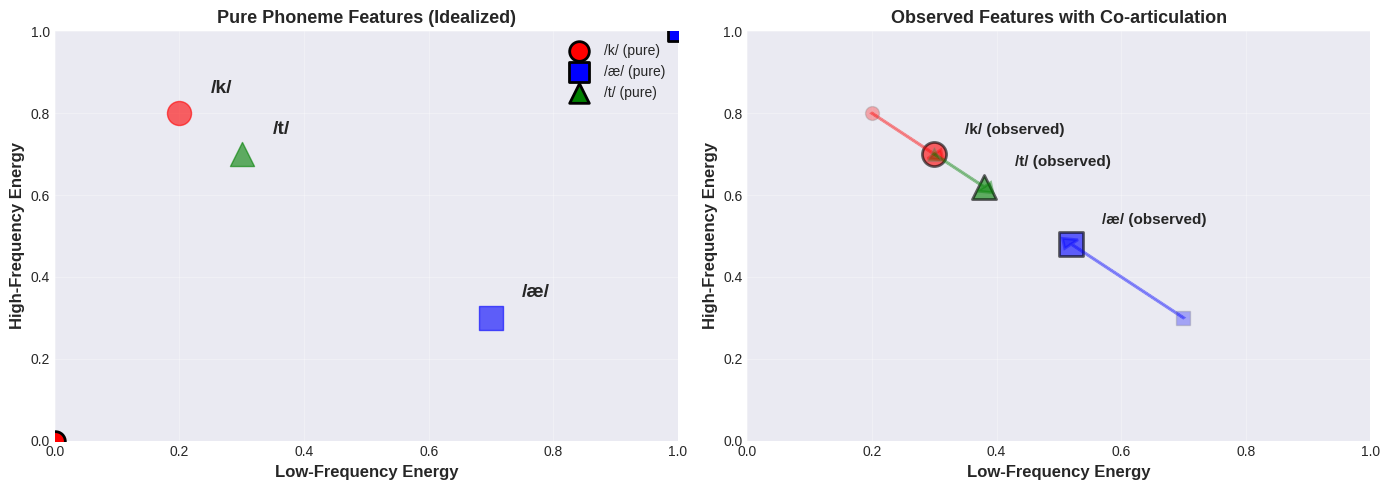


Observations:
  • Pure /æ/ is at (0.7, 0.3)
  • Observed /æ/ is at (0.52, 0.48)
  • Shift due to co-articulation: Δ = (-0.18, 0.18)

This shift makes frame-by-frame classification ambiguous!
The RNN's hidden state helps track these transitions.


In [5]:
# Demonstrate co-articulation mathematically
print("\n" + "="*70)
print("MATHEMATICAL MODEL OF CO-ARTICULATION")
print("="*70)

print("\nSimplified model: Current frame features are a weighted combination")
print("of current and adjacent phonemes:")
print("\n  F(t) = α·P(t-1) + β·P(t) + γ·P(t+1)")
print("\nwhere:")
print("  • F(t) = observed features at time t")
print("  • P(t) = 'pure' phoneme features at time t")
print("  • α, β, γ = co-articulation weights (α + β + γ = 1)")
print("\nTypical values: α ≈ 0.2, β ≈ 0.6, γ ≈ 0.2")

# Simulate this
def simulate_coarticulation(phoneme_sequence, alpha=0.2, beta=0.6, gamma=0.2):
    """
    Simulate co-articulation effects on a phoneme sequence
    phoneme_sequence: list of feature vectors (one per phoneme)
    """
    n = len(phoneme_sequence)
    observed_features = []
    
    for t in range(n):
        # Get adjacent phonemes (with boundary handling)
        prev_phoneme = phoneme_sequence[t-1] if t > 0 else phoneme_sequence[t]
        curr_phoneme = phoneme_sequence[t]
        next_phoneme = phoneme_sequence[t+1] if t < n-1 else phoneme_sequence[t]
        
        # Mix features
        observed = (alpha * prev_phoneme + 
                   beta * curr_phoneme + 
                   gamma * next_phoneme)
        observed_features.append(observed)
    
    return np.array(observed_features)

# Example: /kæt/ sequence
# Simplified 2D feature space: [low_freq_energy, high_freq_energy]
phoneme_features = {
    'k': np.array([0.2, 0.8]),  # High-frequency burst
    'æ': np.array([0.7, 0.3]),  # Low-frequency vowel
    't': np.array([0.3, 0.7])   # High-frequency burst
}

sequence = [phoneme_features['k'], phoneme_features['æ'], phoneme_features['t']]
observed = simulate_coarticulation(sequence)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pure phonemes
ax1.scatter([0], [0], s=200, c='red', marker='o', label='/k/ (pure)', edgecolors='black', linewidths=2)
ax1.scatter([1], [1], s=200, c='blue', marker='s', label='/æ/ (pure)', edgecolors='black', linewidths=2)
ax1.scatter([2], [2], s=200, c='green', marker='^', label='/t/ (pure)', edgecolors='black', linewidths=2)

for i, (label, feat) in enumerate(phoneme_features.items()):
    ax1.scatter(feat[0], feat[1], s=300, alpha=0.6, 
               c=['red', 'blue', 'green'][i], 
               marker=['o', 's', '^'][i])
    ax1.annotate(f'/{label}/', xy=(feat[0], feat[1]), 
                xytext=(feat[0]+0.05, feat[1]+0.05),
                fontsize=14, fontweight='bold')

ax1.set_xlabel('Low-Frequency Energy', fontsize=12, fontweight='bold')
ax1.set_ylabel('High-Frequency Energy', fontsize=12, fontweight='bold')
ax1.set_title('Pure Phoneme Features (Idealized)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.legend(fontsize=10)

# Observed features with co-articulation
labels_seq = ['k', 'æ', 't']
colors_seq = ['red', 'blue', 'green']
markers_seq = ['o', 's', '^']

for i, (obs, label, color, marker) in enumerate(zip(observed, labels_seq, colors_seq, markers_seq)):
    ax2.scatter(obs[0], obs[1], s=300, c=color, marker=marker, alpha=0.6, edgecolors='black', linewidths=2)
    ax2.annotate(f'/{label}/ (observed)', xy=(obs[0], obs[1]),
                xytext=(obs[0]+0.05, obs[1]+0.05),
                fontsize=11, fontweight='bold')
    
    # Draw arrow from pure to observed
    pure = sequence[i]
    ax2.arrow(pure[0], pure[1], obs[0]-pure[0], obs[1]-pure[1],
             head_width=0.03, head_length=0.02, fc=color, ec=color, alpha=0.4, linewidth=2)

# Also plot pure positions for reference
for i, (label, feat) in enumerate(phoneme_features.items()):
    ax2.scatter(feat[0], feat[1], s=100, alpha=0.3, c=colors_seq[i], 
               marker=markers_seq[i], edgecolors='gray', linewidths=1)

ax2.set_xlabel('Low-Frequency Energy', fontsize=12, fontweight='bold')
ax2.set_ylabel('High-Frequency Energy', fontsize=12, fontweight='bold')
ax2.set_title('Observed Features with Co-articulation', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\nObservations:")
print("  • Pure /æ/ is at (0.7, 0.3)")
print(f"  • Observed /æ/ is at ({observed[1][0]:.2f}, {observed[1][1]:.2f})")
print(f"  • Shift due to co-articulation: Δ = ({observed[1][0]-0.7:.2f}, {observed[1][1]-0.3:.2f})")
print("\nThis shift makes frame-by-frame classification ambiguous!")
print("The RNN's hidden state helps track these transitions.")

**Summary: Why RNNs Are Essential for Speech Recognition**

In [6]:
print("\n" + "="*80)
print("WHY RNNs OUTPERFORM FRAME-BY-FRAME DNNs FOR SPEECH RECOGNITION")
print("="*80)

summary = """
1. CO-ARTICULATION CREATES TEMPORAL DEPENDENCIES
   • Phonemes blend and influence each other
   • Current frame contains information from adjacent phonemes
   • Same phoneme has different acoustic realizations depending on context

2. IMPERFECT FRAME BOUNDARIES
   • Audio frames don't align with phoneme boundaries
   • A single frame may contain parts of multiple phonemes
   • Phoneme durations vary (some span multiple frames)

3. ACOUSTIC VARIABILITY
   • Same phoneme sounds different across speakers
   • Speaking rate affects temporal structure
   • Context helps constrain interpretation

4. RNN ADVANTAGES
   • Hidden state accumulates temporal context
   • Can track transitions and disambiguate similar sounds
   • Learns to recognize patterns across time
   • Handles variable-length sequences naturally

5. REAL-WORLD IMPACT
   • Modern speech recognition uses RNNs/LSTMs/Transformers
   • Frame-by-frame DNNs achieve ~60-70% accuracy
   • Temporal models achieve ~95%+ accuracy
   • The difference is entirely due to temporal modeling!
"""

print(summary)
print("="*80)


WHY RNNs OUTPERFORM FRAME-BY-FRAME DNNs FOR SPEECH RECOGNITION

1. CO-ARTICULATION CREATES TEMPORAL DEPENDENCIES
   • Phonemes blend and influence each other
   • Current frame contains information from adjacent phonemes
   • Same phoneme has different acoustic realizations depending on context

2. IMPERFECT FRAME BOUNDARIES
   • Audio frames don't align with phoneme boundaries
   • A single frame may contain parts of multiple phonemes
   • Phoneme durations vary (some span multiple frames)

3. ACOUSTIC VARIABILITY
   • Same phoneme sounds different across speakers
   • Speaking rate affects temporal structure
   • Context helps constrain interpretation

4. RNN ADVANTAGES
   • Hidden state accumulates temporal context
   • Can track transitions and disambiguate similar sounds
   • Learns to recognize patterns across time
   • Handles variable-length sequences naturally

5. REAL-WORLD IMPACT
   • Modern speech recognition uses RNNs/LSTMs/Transformers
   • Frame-by-frame DNNs achieve ~6

## 1. Activation Functions for RNNs

Before building our RNN, let's understand the activation functions we'll use.

### Why tanh for Hidden States?

In RNNs, we use **tanh (hyperbolic tangent)** for the hidden state activation:

$$h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$$

**Properties of tanh**:
- Range: [-1, 1]
- Symmetric around zero
- Allows both positive and negative values
- Better gradient flow than sigmoid

**Why NOT ReLU?**
- ReLU is unbounded [0, ∞) → can cause instability over time
- ReLU can't represent negative temporal patterns
- tanh provides stability with bounded output

### Softmax for Output

For the output layer (phoneme classification), we use **softmax**:

$$y_t = \text{softmax}(W_{hy} h_t + b_y)$$

This converts scores to probabilities that sum to 1.

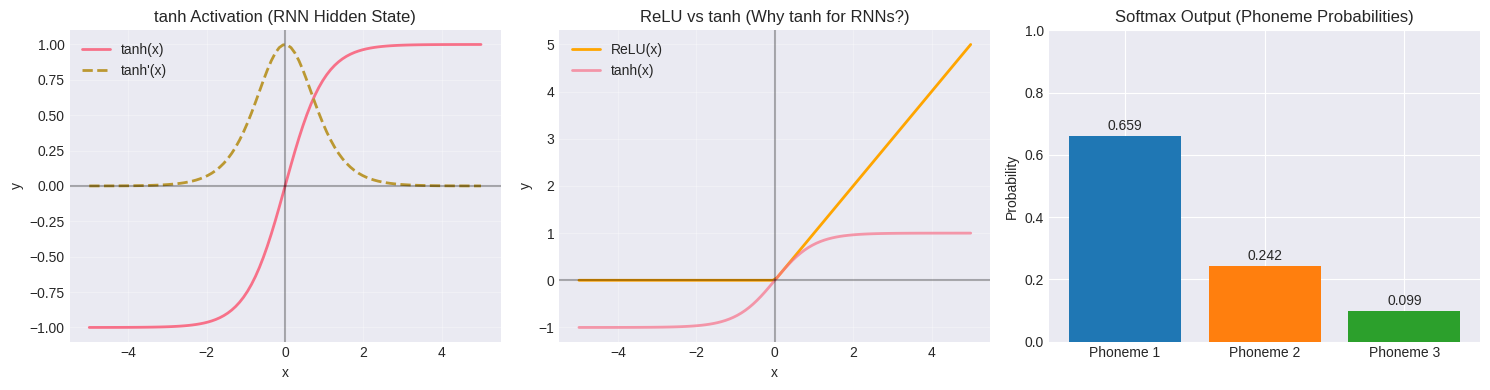


✓ Activation functions defined and visualized
  - tanh range: [-1.000, 1.000]
  - Softmax output sums to: 1.000000


In [7]:
# Activation functions
def tanh(x):
    """Hyperbolic tangent activation function.
    
    Args:
        x: Input array
    
    Returns:
        Output in range [-1, 1]
    """
    return np.tanh(x)

def tanh_derivative(x):
    """Derivative of tanh.
    
    Args:
        x: Input array (output of tanh)
    
    Returns:
        Gradient
    """
    return 1 - np.tanh(x) ** 2

def softmax(x):
    """Softmax activation function.
    
    Args:
        x: Input array of shape (n_classes,) or (batch_size, n_classes)
    
    Returns:
        Probabilities that sum to 1
    """
    # Subtract max for numerical stability
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# Visualize activation functions
x = np.linspace(-5, 5, 100)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# tanh
axes[0].plot(x, tanh(x), linewidth=2, label='tanh(x)')
axes[0].plot(x, tanh_derivative(x), linewidth=2, label="tanh'(x)", linestyle='--')
axes[0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[0].axvline(x=0, color='k', linestyle='-', alpha=0.3)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('tanh Activation (RNN Hidden State)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ReLU for comparison
relu = np.maximum(0, x)
axes[1].plot(x, relu, linewidth=2, label='ReLU(x)', color='orange')
axes[1].plot(x, tanh(x), linewidth=2, label='tanh(x)', alpha=0.7)
axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1].axvline(x=0, color='k', linestyle='-', alpha=0.3)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('ReLU vs tanh (Why tanh for RNNs?)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Softmax example
logits = np.array([2.0, 1.0, 0.1])
probs = softmax(logits)
axes[2].bar(['Phoneme 1', 'Phoneme 2', 'Phoneme 3'], probs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[2].set_ylabel('Probability')
axes[2].set_title('Softmax Output (Phoneme Probabilities)')
axes[2].set_ylim([0, 1])
for i, p in enumerate(probs):
    axes[2].text(i, p + 0.02, f'{p:.3f}', ha='center')

plt.tight_layout()
plt.show()

print("\n✓ Activation functions defined and visualized")
print(f"  - tanh range: [{tanh(-10):.3f}, {tanh(10):.3f}]")
print(f"  - Softmax output sums to: {np.sum(probs):.6f}")

## 2. Generate Synthetic Phoneme Dataset

For learning purposes, we'll create a simplified synthetic dataset.

### Dataset Design

- **Phonemes**: 5 phonemes {/a/, /e/, /i/, /o/, /u/}
- **Sequences**: Simple patterns like "aei", "oua", "ieo"
- **Features**: 8-dimensional "audio" features (simplified MFCCs)
- **Temporal dependency**: Each phoneme's features depend slightly on the previous phoneme

This creates a problem where temporal context is necessary for accurate classification.

Dataset generated successfully!

Training set:
  X_train shape: (500, 10, 8) (n_sequences, seq_length, feature_dim)
  y_train shape: (500, 10) (n_sequences, seq_length)

Validation set:
  X_val shape: (100, 10, 8)
  y_val shape: (100, 10)

Phonemes: ['a', 'e', 'i', 'o', 'u']


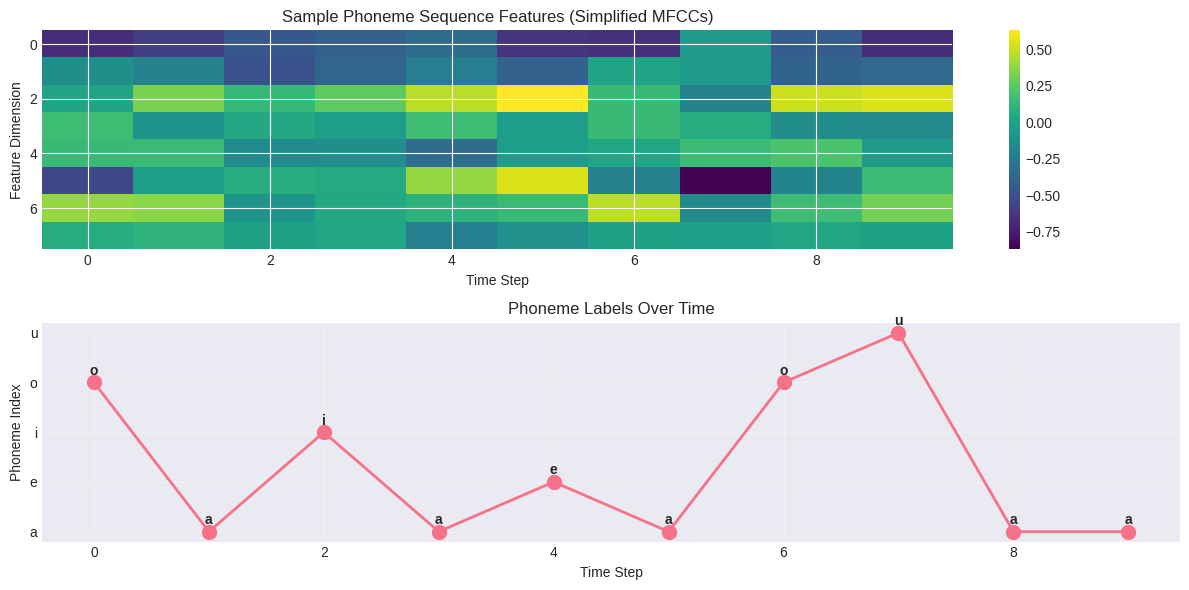


Sample sequence: ['o', 'a', 'i', 'a', 'e', 'a', 'o', 'u', 'a', 'a']


In [8]:
class PhonemeDataset:
    """Generate synthetic phoneme sequences for RNN training."""
    
    def __init__(self, n_phonemes=5, feature_dim=8, seq_length=10):
        """
        Args:
            n_phonemes: Number of unique phonemes
            feature_dim: Dimension of audio features
            seq_length: Length of each sequence
        """
        self.n_phonemes = n_phonemes
        self.feature_dim = feature_dim
        self.seq_length = seq_length
        
        # Phoneme names
        self.phoneme_names = ['a', 'e', 'i', 'o', 'u'][:n_phonemes]
        
        # Create unique "signature" for each phoneme
        # Each phoneme has a characteristic feature pattern
        self.phoneme_signatures = np.random.randn(n_phonemes, feature_dim)
        
        # Normalize signatures
        self.phoneme_signatures = self.phoneme_signatures / np.linalg.norm(
            self.phoneme_signatures, axis=1, keepdims=True
        )
    
    def generate_sequence(self):
        """Generate a single phoneme sequence.
        
        Returns:
            features: (seq_length, feature_dim) array
            labels: (seq_length,) array of phoneme indices
        """
        # Random phoneme sequence
        labels = np.random.randint(0, self.n_phonemes, size=self.seq_length)
        
        features = np.zeros((self.seq_length, self.feature_dim))
        
        for t in range(self.seq_length):
            # Base feature from phoneme signature
            base_feature = self.phoneme_signatures[labels[t]]
            
            # Add temporal dependency: current features depend on previous phoneme
            if t > 0:
                prev_feature = self.phoneme_signatures[labels[t-1]]
                # Mix current and previous (co-articulation effect)
                features[t] = 0.7 * base_feature + 0.3 * prev_feature
            else:
                features[t] = base_feature
            
            # Add noise
            features[t] += np.random.randn(self.feature_dim) * 0.1
        
        return features, labels
    
    def generate_dataset(self, n_sequences):
        """Generate multiple sequences.
        
        Args:
            n_sequences: Number of sequences to generate
        
        Returns:
            X: (n_sequences, seq_length, feature_dim) array
            y: (n_sequences, seq_length) array
        """
        X = np.zeros((n_sequences, self.seq_length, self.feature_dim))
        y = np.zeros((n_sequences, self.seq_length), dtype=int)
        
        for i in range(n_sequences):
            X[i], y[i] = self.generate_sequence()
        
        return X, y

# Create dataset
dataset = PhonemeDataset(n_phonemes=5, feature_dim=8, seq_length=10)

# Generate training and validation data
X_train, y_train = dataset.generate_dataset(n_sequences=500)
X_val, y_val = dataset.generate_dataset(n_sequences=100)

print("Dataset generated successfully!")
print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape} (n_sequences, seq_length, feature_dim)")
print(f"  y_train shape: {y_train.shape} (n_sequences, seq_length)")
print(f"\nValidation set:")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"\nPhonemes: {dataset.phoneme_names}")

# Visualize a sample sequence
sample_idx = 0
sample_features = X_train[sample_idx]
sample_labels = y_train[sample_idx]

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Plot features
im = axes[0].imshow(sample_features.T, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Feature Dimension')
axes[0].set_title('Sample Phoneme Sequence Features (Simplified MFCCs)')
plt.colorbar(im, ax=axes[0])

# Plot labels
axes[1].plot(sample_labels, 'o-', markersize=10, linewidth=2)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Phoneme Index')
axes[1].set_title('Phoneme Labels Over Time')
axes[1].set_yticks(range(dataset.n_phonemes))
axes[1].set_yticklabels(dataset.phoneme_names)
axes[1].grid(True, alpha=0.3)

# Add phoneme names as text
for t, label in enumerate(sample_labels):
    axes[1].text(t, label + 0.15, dataset.phoneme_names[label], 
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nSample sequence: {[dataset.phoneme_names[l] for l in sample_labels]}")

## 3. Simple RNN Implementation from Scratch

Now let's implement a simple RNN using pure NumPy.

### RNN Architecture

At each timestep $t$:

1. **Hidden state update**:
   $$h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$$

2. **Output computation**:
   $$y_t = \text{softmax}(W_{hy} h_t + b_y)$$

Where:
- $x_t$: input at time $t$ (audio features)
- $h_t$: hidden state at time $t$ (memory/context)
- $y_t$: output at time $t$ (phoneme probabilities)
- $W_{xh}$: input-to-hidden weights
- $W_{hh}$: hidden-to-hidden weights (recurrent connection)
- $W_{hy}$: hidden-to-output weights
- $b_h$, $b_y$: biases

In [9]:
class SimpleRNN:
    """Simple RNN implementation from scratch."""
    
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01):
        """
        Args:
            input_dim: Dimension of input features
            hidden_dim: Dimension of hidden state
            output_dim: Number of output classes (phonemes)
            learning_rate: Learning rate for gradient descent
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        
        # Initialize weights (Xavier initialization)
        self.W_xh = np.random.randn(hidden_dim, input_dim) * np.sqrt(2.0 / input_dim)
        self.W_hh = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2.0 / hidden_dim)
        self.W_hy = np.random.randn(output_dim, hidden_dim) * np.sqrt(2.0 / hidden_dim)
        
        # Initialize biases
        self.b_h = np.zeros((hidden_dim, 1))
        self.b_y = np.zeros((output_dim, 1))
        
        # For tracking training
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    def forward(self, X):
        """Forward pass through the RNN.
        
        Args:
            X: Input sequence of shape (seq_length, input_dim)
        
        Returns:
            outputs: List of output probabilities at each timestep
            hidden_states: List of hidden states at each timestep
        """
        seq_length = X.shape[0]
        
        # Initialize hidden state
        h = np.zeros((self.hidden_dim, 1))
        
        hidden_states = []
        outputs = []
        
        for t in range(seq_length):
            # Get input at time t
            x_t = X[t].reshape(-1, 1)  # (input_dim, 1)
            
            # Update hidden state
            h = tanh(np.dot(self.W_hh, h) + np.dot(self.W_xh, x_t) + self.b_h)
            
            # Compute output
            logits = np.dot(self.W_hy, h) + self.b_y
            y_t = softmax(logits.flatten())
            
            hidden_states.append(h.copy())
            outputs.append(y_t)
        
        return outputs, hidden_states
    
    def compute_loss(self, outputs, targets):
        """Compute cross-entropy loss.
        
        Args:
            outputs: List of output probabilities
            targets: Array of target labels (seq_length,)
        
        Returns:
            loss: Average cross-entropy loss
        """
        seq_length = len(outputs)
        loss = 0.0
        
        for t in range(seq_length):
            # Cross-entropy loss at timestep t
            loss += -np.log(outputs[t][targets[t]] + 1e-8)
        
        return loss / seq_length
    
    def backward(self, X, targets, outputs, hidden_states):
        """Backpropagation through time (BPTT) - simplified version.
        
        Args:
            X: Input sequence
            targets: Target labels
            outputs: Forward pass outputs
            hidden_states: Forward pass hidden states
        
        Returns:
            Gradients for all parameters
        """
        seq_length = X.shape[0]
        
        # Initialize gradients
        dW_xh = np.zeros_like(self.W_xh)
        dW_hh = np.zeros_like(self.W_hh)
        dW_hy = np.zeros_like(self.W_hy)
        db_h = np.zeros_like(self.b_h)
        db_y = np.zeros_like(self.b_y)
        
        # Gradient of hidden state from next timestep
        dh_next = np.zeros((self.hidden_dim, 1))
        
        # Backward pass through time
        for t in reversed(range(seq_length)):
            # Output gradient
            dy = outputs[t].copy()
            dy[targets[t]] -= 1  # Softmax + cross-entropy gradient
            dy = dy.reshape(-1, 1) / seq_length  # Average over sequence
            
            # Gradients for output layer
            dW_hy += np.dot(dy, hidden_states[t].T)
            db_y += dy
            
            # Gradient flowing back to hidden state
            dh = np.dot(self.W_hy.T, dy) + dh_next
            
            # Gradient through tanh
            dh_raw = dh * (1 - hidden_states[t] ** 2)
            
            # Gradients for hidden layer
            x_t = X[t].reshape(-1, 1)
            dW_xh += np.dot(dh_raw, x_t.T)
            db_h += dh_raw
            
            if t > 0:
                dW_hh += np.dot(dh_raw, hidden_states[t-1].T)
                dh_next = np.dot(self.W_hh.T, dh_raw)
            else:
                h_prev = np.zeros((self.hidden_dim, 1))
                dW_hh += np.dot(dh_raw, h_prev.T)
        
        # Gradient clipping (prevent exploding gradients)
        for grad in [dW_xh, dW_hh, dW_hy, db_h, db_y]:
            np.clip(grad, -5, 5, out=grad)
        
        return dW_xh, dW_hh, dW_hy, db_h, db_y
    
    def update_parameters(self, dW_xh, dW_hh, dW_hy, db_h, db_y):
        """Update parameters using gradients."""
        self.W_xh -= self.learning_rate * dW_xh
        self.W_hh -= self.learning_rate * dW_hh
        self.W_hy -= self.learning_rate * dW_hy
        self.b_h -= self.learning_rate * db_h
        self.b_y -= self.learning_rate * db_y
    
    def train_step(self, X, y):
        """Single training step.
        
        Args:
            X: Input sequence
            y: Target labels
        
        Returns:
            loss: Training loss
        """
        # Forward pass
        outputs, hidden_states = self.forward(X)
        
        # Compute loss
        loss = self.compute_loss(outputs, y)
        
        # Backward pass
        grads = self.backward(X, y, outputs, hidden_states)
        
        # Update parameters
        self.update_parameters(*grads)
        
        return loss
    
    def predict(self, X):
        """Make predictions.
        
        Args:
            X: Input sequence
        
        Returns:
            predictions: Array of predicted labels
        """
        outputs, _ = self.forward(X)
        predictions = np.array([np.argmax(out) for out in outputs])
        return predictions
    
    def evaluate(self, X, y):
        """Evaluate on a dataset.
        
        Args:
            X: Input sequences (n_sequences, seq_length, input_dim)
            y: Target labels (n_sequences, seq_length)
        
        Returns:
            avg_loss: Average loss
            accuracy: Frame-level accuracy
        """
        total_loss = 0.0
        correct = 0
        total = 0
        
        for i in range(len(X)):
            outputs, _ = self.forward(X[i])
            loss = self.compute_loss(outputs, y[i])
            total_loss += loss
            
            predictions = np.array([np.argmax(out) for out in outputs])
            correct += np.sum(predictions == y[i])
            total += len(y[i])
        
        avg_loss = total_loss / len(X)
        accuracy = correct / total
        
        return avg_loss, accuracy

print("✓ SimpleRNN class implemented")
print("\nRNN Architecture:")
print("  h_t = tanh(W_hh * h_{t-1} + W_xh * x_t + b_h)")
print("  y_t = softmax(W_hy * h_t + b_y)")

✓ SimpleRNN class implemented

RNN Architecture:
  h_t = tanh(W_hh * h_{t-1} + W_xh * x_t + b_h)
  y_t = softmax(W_hy * h_t + b_y)


## 4. Train the RNN

Now let's train our RNN on the phoneme sequence recognition task.

In [10]:
# Initialize RNN
rnn = SimpleRNN(
    input_dim=dataset.feature_dim,
    hidden_dim=32,
    output_dim=dataset.n_phonemes,
    learning_rate=0.01
)

print("RNN initialized with:")
print(f"  Input dim: {rnn.input_dim}")
print(f"  Hidden dim: {rnn.hidden_dim}")
print(f"  Output dim: {rnn.output_dim}")
print(f"  Learning rate: {rnn.learning_rate}")
print(f"\nTotal parameters: {rnn.W_xh.size + rnn.W_hh.size + rnn.W_hy.size + rnn.b_h.size + rnn.b_y.size}")

# Training loop
n_epochs = 50
print(f"\nTraining for {n_epochs} epochs...\n")

for epoch in range(n_epochs):
    # Shuffle training data
    indices = np.random.permutation(len(X_train))
    
    # Train on each sequence
    epoch_loss = 0.0
    for idx in indices:
        loss = rnn.train_step(X_train[idx], y_train[idx])
        epoch_loss += loss
    
    # Evaluate
    train_loss, train_acc = rnn.evaluate(X_train, y_train)
    val_loss, val_acc = rnn.evaluate(X_val, y_val)
    
    rnn.train_losses.append(train_loss)
    rnn.val_losses.append(val_loss)
    rnn.train_accuracies.append(train_acc)
    rnn.val_accuracies.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\n✓ Training complete!")

RNN initialized with:
  Input dim: 8
  Hidden dim: 32
  Output dim: 5
  Learning rate: 0.01

Total parameters: 1477

Training for 50 epochs...

Epoch 10/50:
  Train Loss: 0.0542, Train Acc: 0.9994
  Val Loss: 0.0563, Val Acc: 1.0000
Epoch 20/50:
  Train Loss: 0.0244, Train Acc: 0.9996
  Val Loss: 0.0267, Val Acc: 1.0000
Epoch 30/50:
  Train Loss: 0.0157, Train Acc: 0.9998
  Val Loss: 0.0182, Val Acc: 1.0000
Epoch 40/50:
  Train Loss: 0.0116, Train Acc: 1.0000
  Val Loss: 0.0141, Val Acc: 1.0000
Epoch 50/50:
  Train Loss: 0.0092, Train Acc: 1.0000
  Val Loss: 0.0118, Val Acc: 1.0000

✓ Training complete!


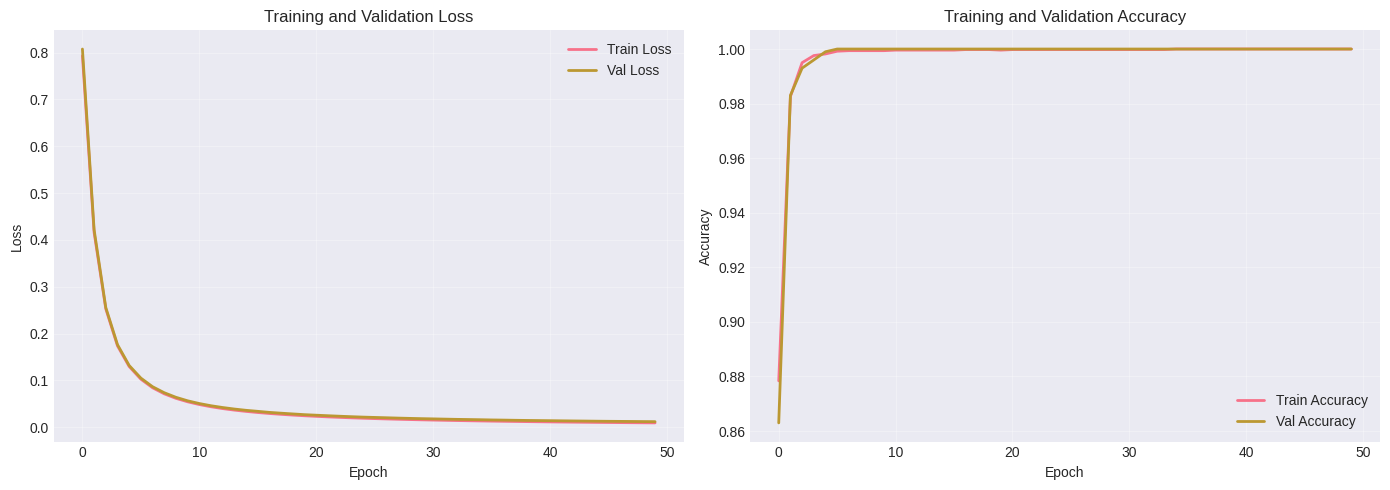


Final Results:
  Train Accuracy: 1.0000
  Val Accuracy: 1.0000


In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(rnn.train_losses, label='Train Loss', linewidth=2)
axes[0].plot(rnn.val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(rnn.train_accuracies, label='Train Accuracy', linewidth=2)
axes[1].plot(rnn.val_accuracies, label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Train Accuracy: {rnn.train_accuracies[-1]:.4f}")
print(f"  Val Accuracy: {rnn.val_accuracies[-1]:.4f}")

## 5. Visualize RNN Predictions and Hidden States

Let's examine what the RNN learned by visualizing:
1. Predictions vs actual labels
2. Hidden state evolution over time

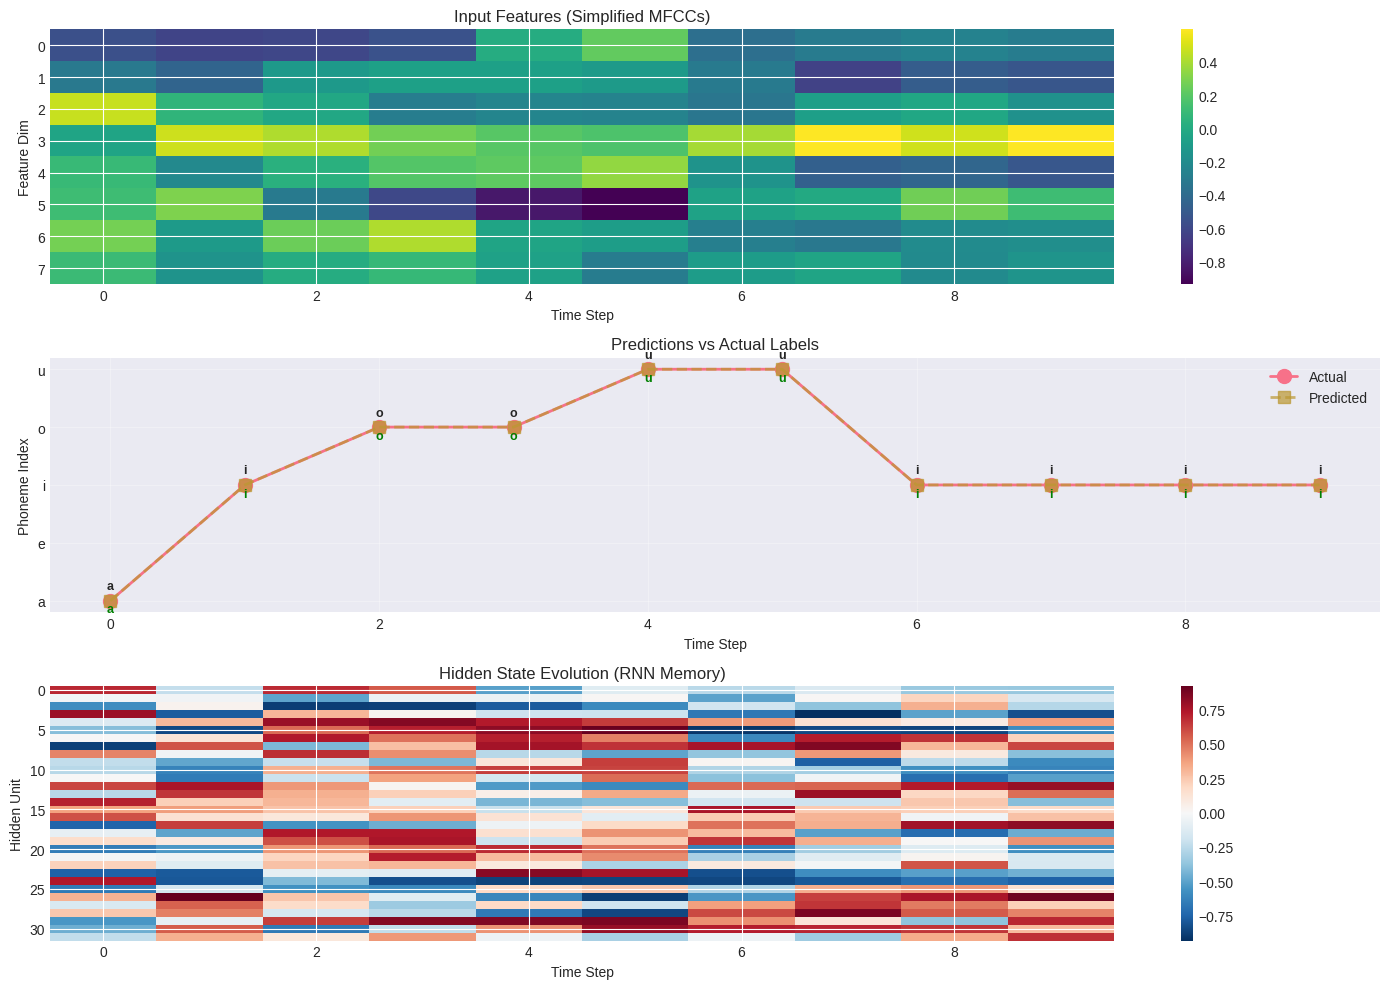


Sequence Accuracy: 100.00%
Correct predictions: 10/10


In [12]:
# Select a test sequence
test_idx = 5
test_X = X_val[test_idx]
test_y = y_val[test_idx]

# Get predictions and hidden states
outputs, hidden_states = rnn.forward(test_X)
predictions = np.array([np.argmax(out) for out in outputs])

# Convert hidden states to array
hidden_states_array = np.array([h.flatten() for h in hidden_states])

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Input features
im1 = axes[0].imshow(test_X.T, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Feature Dim')
axes[0].set_title('Input Features (Simplified MFCCs)')
plt.colorbar(im1, ax=axes[0])

# 2. Predictions vs Actual
time_steps = np.arange(len(test_y))
axes[1].plot(time_steps, test_y, 'o-', label='Actual', markersize=10, linewidth=2)
axes[1].plot(time_steps, predictions, 's--', label='Predicted', markersize=8, linewidth=2, alpha=0.7)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Phoneme Index')
axes[1].set_title('Predictions vs Actual Labels')
axes[1].set_yticks(range(dataset.n_phonemes))
axes[1].set_yticklabels(dataset.phoneme_names)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add text labels
for t in range(len(test_y)):
    actual_name = dataset.phoneme_names[test_y[t]]
    pred_name = dataset.phoneme_names[predictions[t]]
    color = 'green' if test_y[t] == predictions[t] else 'red'
    axes[1].text(t, test_y[t] + 0.2, actual_name, ha='center', fontsize=9, fontweight='bold')
    axes[1].text(t, predictions[t] - 0.2, pred_name, ha='center', fontsize=9, 
                fontweight='bold', color=color)

# 3. Hidden state evolution
im3 = axes[2].imshow(hidden_states_array.T, aspect='auto', cmap='RdBu_r', interpolation='nearest')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Hidden Unit')
axes[2].set_title('Hidden State Evolution (RNN Memory)')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# Calculate accuracy for this sequence
seq_accuracy = np.mean(predictions == test_y)
print(f"\nSequence Accuracy: {seq_accuracy:.2%}")
print(f"Correct predictions: {np.sum(predictions == test_y)}/{len(test_y)}")

## 6. Baseline Comparison: DNN vs RNN

To demonstrate why RNNs are necessary, let's compare with a simple DNN that looks at each frame independently (no temporal context).

In [13]:
class SimpleDNN:
    """Simple feedforward DNN for comparison (no temporal context)."""
    
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        
        # Initialize weights
        self.W1 = np.random.randn(hidden_dim, input_dim) * np.sqrt(2.0 / input_dim)
        self.W2 = np.random.randn(output_dim, hidden_dim) * np.sqrt(2.0 / hidden_dim)
        self.b1 = np.zeros((hidden_dim, 1))
        self.b2 = np.zeros((output_dim, 1))
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    def forward(self, x):
        """Forward pass (single frame, no temporal context)."""
        x = x.reshape(-1, 1)
        h = tanh(np.dot(self.W1, x) + self.b1)
        logits = np.dot(self.W2, h) + self.b2
        y = softmax(logits.flatten())
        return y, h
    
    def train_step(self, X, y):
        """Train on a sequence (treating each frame independently)."""
        seq_length = X.shape[0]
        total_loss = 0.0
        
        for t in range(seq_length):
            # Forward pass
            output, h = self.forward(X[t])
            
            # Loss
            loss = -np.log(output[y[t]] + 1e-8)
            total_loss += loss
            
            # Backward pass
            dy = output.copy()
            dy[y[t]] -= 1
            dy = dy.reshape(-1, 1)
            
            dW2 = np.dot(dy, h.T)
            db2 = dy
            
            dh = np.dot(self.W2.T, dy)
            dh_raw = dh * (1 - h ** 2)
            
            x = X[t].reshape(-1, 1)
            dW1 = np.dot(dh_raw, x.T)
            db1 = dh_raw
            
            # Update
            self.W2 -= self.learning_rate * dW2
            self.b2 -= self.learning_rate * db2
            self.W1 -= self.learning_rate * dW1
            self.b1 -= self.learning_rate * db1
        
        return total_loss / seq_length
    
    def predict(self, X):
        """Predict for a sequence."""
        predictions = []
        for t in range(X.shape[0]):
            output, _ = self.forward(X[t])
            predictions.append(np.argmax(output))
        return np.array(predictions)
    
    def evaluate(self, X, y):
        """Evaluate on dataset."""
        total_loss = 0.0
        correct = 0
        total = 0
        
        for i in range(len(X)):
            for t in range(X[i].shape[0]):
                output, _ = self.forward(X[i][t])
                loss = -np.log(output[y[i][t]] + 1e-8)
                total_loss += loss
                
                if np.argmax(output) == y[i][t]:
                    correct += 1
                total += 1
        
        return total_loss / total, correct / total

# Train DNN
dnn = SimpleDNN(
    input_dim=dataset.feature_dim,
    hidden_dim=32,
    output_dim=dataset.n_phonemes,
    learning_rate=0.01
)

print("Training DNN baseline (no temporal context)...\n")

for epoch in range(n_epochs):
    indices = np.random.permutation(len(X_train))
    
    for idx in indices:
        dnn.train_step(X_train[idx], y_train[idx])
    
    train_loss, train_acc = dnn.evaluate(X_train, y_train)
    val_loss, val_acc = dnn.evaluate(X_val, y_val)
    
    dnn.train_losses.append(train_loss)
    dnn.val_losses.append(val_loss)
    dnn.train_accuracies.append(train_acc)
    dnn.val_accuracies.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}: Val Acc: {val_acc:.4f}")

print("\n✓ DNN training complete!")

Training DNN baseline (no temporal context)...

Epoch 10/50: Val Acc: 0.9950
Epoch 20/50: Val Acc: 0.9940
Epoch 30/50: Val Acc: 0.9920
Epoch 40/50: Val Acc: 0.9930
Epoch 50/50: Val Acc: 0.9930

✓ DNN training complete!


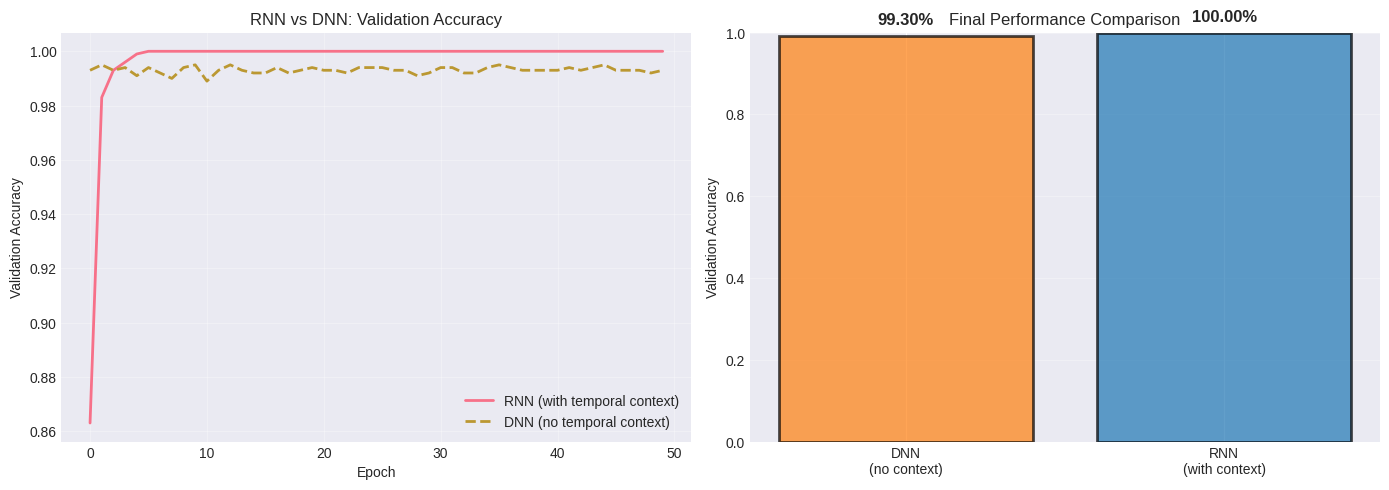


FINAL RESULTS COMPARISON

DNN (no temporal context):
  Validation Accuracy: 99.30%

RNN (with temporal context):
  Validation Accuracy: 100.00%

Improvement: 0.70%



In [14]:
# Compare RNN vs DNN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].plot(rnn.val_accuracies, label='RNN (with temporal context)', linewidth=2)
axes[0].plot(dnn.val_accuracies, label='DNN (no temporal context)', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('RNN vs DNN: Validation Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Final comparison bar chart
models = ['DNN\n(no context)', 'RNN\n(with context)']
accuracies = [dnn.val_accuracies[-1], rnn.val_accuracies[-1]]
colors = ['#ff7f0e', '#1f77b4']

bars = axes[1].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Final Performance Comparison')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{acc:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL RESULTS COMPARISON")
print("="*50)
print(f"\nDNN (no temporal context):")
print(f"  Validation Accuracy: {dnn.val_accuracies[-1]:.2%}")
print(f"\nRNN (with temporal context):")
print(f"  Validation Accuracy: {rnn.val_accuracies[-1]:.2%}")
print(f"\nImprovement: {(rnn.val_accuracies[-1] - dnn.val_accuracies[-1]):.2%}")
print("\n" + "="*50)

## 7. Limitations and Next Steps

### What We Learned

✅ **RNNs maintain temporal context** through hidden states  
✅ **tanh activation** is used for hidden states (bounded, symmetric)  
✅ **RNNs outperform DNNs** on sequence tasks  
✅ **Backpropagation through time (BPTT)** trains RNNs

### Limitations of Simple RNNs

Despite their success, simple RNNs have significant limitations:

#### 1. **Vanishing Gradient Problem**

During BPTT, gradients are multiplied repeatedly:

$$\frac{\partial L}{\partial h_1} = \frac{\partial L}{\partial h_T} \prod_{t=2}^{T} \frac{\partial h_t}{\partial h_{t-1}}$$

Since $\frac{\partial h_t}{\partial h_{t-1}} = W_{hh} \cdot \text{diag}(1 - h_{t-1}^2)$, and tanh derivatives are ≤ 1:

- If $|W_{hh}| < 1$: gradients **vanish** (→ 0)
- If $|W_{hh}| > 1$: gradients **explode** (→ ∞)

**Result**: Simple RNNs struggle with long-range dependencies (>10 timesteps)

#### 2. **Limited Memory**

The hidden state must compress all past information into a fixed-size vector. For long sequences, early information gets "forgotten".

#### 3. **Slow Training**

Sequential processing (can't parallelize across time) makes training slow.

### Solution: LSTM and GRU

In the next notebooks, we'll learn about:

1. **LSTM (Long Short-Term Memory)**
   - Introduces **gates** (forget, input, output) using sigmoid activation
   - Maintains a **cell state** as a "highway" for gradients
   - Solves vanishing gradient problem
   - Can learn long-range dependencies (100+ timesteps)

2. **GRU (Gated Recurrent Unit)**
   - Simplified version of LSTM
   - Fewer parameters, faster training
   - Often performs similarly to LSTM

### Preview: LSTM Gates

LSTM uses **sigmoid** activation for gates (range [0, 1]):
- 0 = "block completely"
- 1 = "pass completely"

This allows the network to learn what to remember and what to forget!

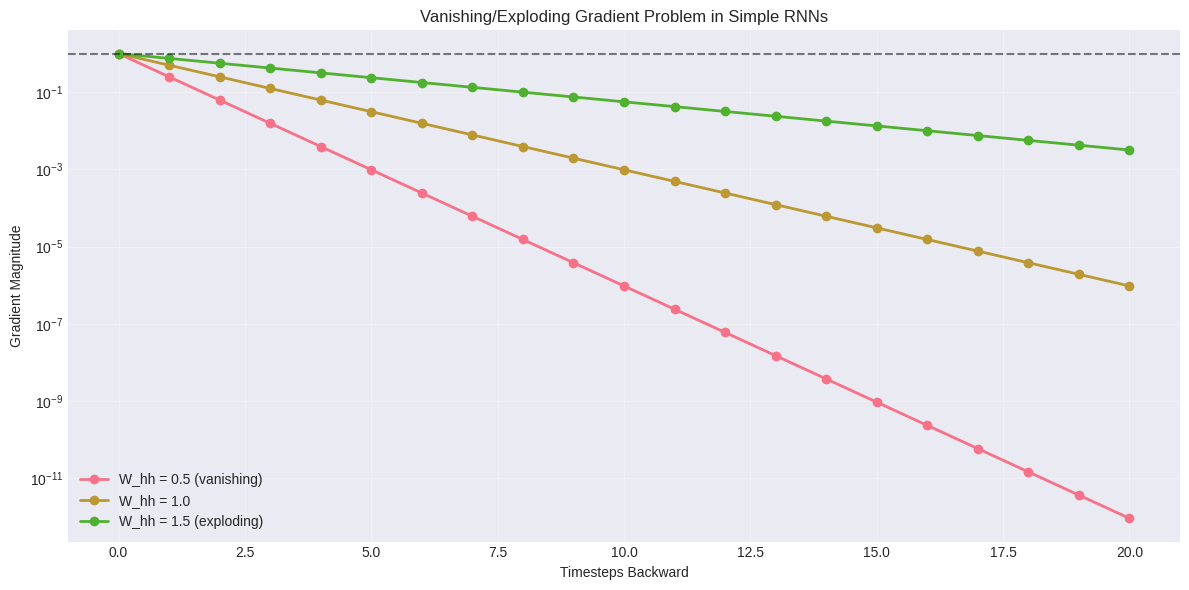


⚠️  Vanishing Gradient Problem:
   - Gradients shrink exponentially as we go back in time
   - Early timesteps receive almost no gradient signal
   - Network can't learn long-range dependencies

✨ Solution: LSTM/GRU (next notebooks!)


In [15]:
# Visualize vanishing gradient problem
def simulate_gradient_flow(W_hh_values, seq_length=20):
    """Simulate how gradients flow through time."""
    results = {}
    
    for W_hh in W_hh_values:
        gradient = 1.0
        gradients = [gradient]
        
        for t in range(seq_length):
            # Simplified: gradient *= W_hh * tanh_derivative
            # Assume tanh_derivative ≈ 0.5 on average
            gradient *= W_hh * 0.5
            gradients.append(gradient)
        
        results[W_hh] = gradients
    
    return results

# Simulate
W_hh_values = [0.5, 1.0, 1.5]
results = simulate_gradient_flow(W_hh_values)

# Plot
plt.figure(figsize=(12, 6))

for W_hh, gradients in results.items():
    label = f'W_hh = {W_hh}'
    if W_hh < 1.0:
        label += ' (vanishing)'
    elif W_hh > 1.0:
        label += ' (exploding)'
    plt.plot(gradients, marker='o', label=label, linewidth=2)

plt.xlabel('Timesteps Backward')
plt.ylabel('Gradient Magnitude')
plt.title('Vanishing/Exploding Gradient Problem in Simple RNNs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Original gradient')
plt.tight_layout()
plt.show()

print("\n⚠️  Vanishing Gradient Problem:")
print("   - Gradients shrink exponentially as we go back in time")
print("   - Early timesteps receive almost no gradient signal")
print("   - Network can't learn long-range dependencies")
print("\n✨ Solution: LSTM/GRU (next notebooks!)")

## Summary

### Key Takeaways

1. **Sequence modeling requires temporal context**
   - Phoneme recognition depends on previous phonemes
   - DNNs fail because they look at single frames
   - RNNs succeed by maintaining hidden state

2. **RNN Architecture**
   - Hidden state: $h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$
   - Output: $y_t = \text{softmax}(W_{hy} h_t + b_y)$
   - tanh activation for hidden states (bounded, symmetric)
   - softmax for output (probabilities)

3. **Training with BPTT**
   - Backpropagation through time
   - Gradient clipping prevents exploding gradients
   - But vanishing gradients still a problem

4. **RNN vs DNN Performance**
   - RNN significantly outperforms DNN on sequence tasks
   - Temporal context is crucial for phoneme recognition

5. **Limitations**
   - Vanishing/exploding gradients
   - Limited long-range dependencies
   - Motivates LSTM/GRU (next notebooks)

### Next Steps

In the next notebooks, we'll explore:
- **Notebook 2**: LSTM architecture and implementation
- **Notebook 3**: GRU architecture and implementation
- **Notebook 4**: LSTM vs GRU comparison

These advanced architectures solve the vanishing gradient problem and enable learning of long-range dependencies!